In [9]:
%matplotlib inline 
from matplotlib import pyplot as plt 

In [10]:
fig_kwargs = {'dpi':200, 'bbox_inches':'tight', 'facecolor':'w'}

In [11]:
import pathlib

In [12]:
import numpy as np
import pandas as pd 
import xarray as xr

In [27]:
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xarray as xr
from dask.diagnostics import ProgressBar

In [14]:
from seasonal_forecasting import C3S, domains, geo, plot, utils, verification

In [15]:
domain_name = "NZ"
use_verif = "oisst"
GCMs = [
    "ECMWF",
    "UKMO",
    "METEO_FRANCE",
    "DWD",
    "CMCC",
    "NCEP",
    "JMA",
    "ECCC_CanCM4i",
    "ECCC_GEM5_NEMO",
]
varname = "sst"
period = "monthly"  # 'seasonal' or 'monthly'
year_start = 1993
year_end = 2016
obs_to_1deg = False
climpred_verbose = False
q = 0.9

In [16]:
domain = domains.domains[domain_name]

In [17]:
domain

[161, 181, -50, -30]

### reads the monthly OISST, see https://downloads.psl.noaa.gov/Datasets/noaa.oisst.v2.highres/ for data source

In [18]:
oisst_path = pathlib.Path("/media/nicolasf/END19101/data/OISST/monthly/global")

In [19]:
lfiles = list(oisst_path.glob("*.nc"))

In [20]:
lfiles.sort()

In [195]:
dset_obs = xr.open_mfdataset(lfiles, parallel=True)

In [196]:
dset_obs = dset_obs.sel(lon=slice(*domain[:2]), lat=slice(*domain[2:]))

### detrend, using coefficient determined over 1993 - 2016

In [202]:
p = dset_obs[varname].sel(time=slice('1993','2016')).polyfit(dim='time', deg=1)

In [203]:
fit = xr.polyval(dset_obs['time'], p.polyfit_coefficients)

In [208]:
dset_obs[f"{varname}_detrend"] = (dset_obs[varname] - fit) + dset_obs[varname].mean(dim='time')

In [209]:
dset_clim = dset_obs.sel(time=slice('1993','2016'))

In [210]:
dset_clim = dset_clim.groupby(dset_clim.time.dt.month).mean()

In [211]:
dset_obs_anoms = dset_obs.groupby(dset_obs.time.dt.month) - dset_clim

/home/nicolasf/mambaforge/envs/seasonal_forecasting/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]


In [212]:
with ProgressBar(): 
    
    dset_obs_anoms = dset_obs_anoms.compute()

[########################################] | 100% Completed | 1.83 sms


In [213]:
dset_obs = dset_obs.chunk({'time':-1, 'lat':10, 'lon':10})

### creates a mask from the observational dataset 

In [214]:
mask_obs = dset_obs.mean(dim="time")

In [215]:
mask_obs = mask_obs.where(np.isnan(mask_obs), 1)

In [216]:
mask_obs = mask_obs.rename({varname: "mask"})["mask"]

### plots the mask 

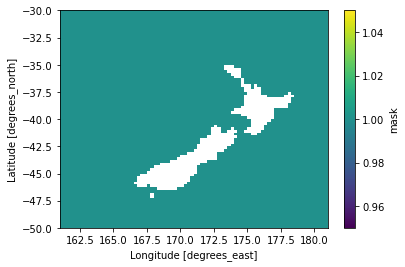

In [217]:
mask_obs.plot()

### calculates seasonal averages if 'seasonal' 

In [218]:
if period == "seasonal":

    dset_obs = dset_obs.rolling({"time": 3}, min_periods=3).mean("time")

    dset_obs = dset_obs.isel(time=slice(2, None))

    dset_obs_anoms = dset_obs_anoms.rolling({"time": 3}, min_periods=3).mean("time")

    dset_obs_anoms = dset_obs_anoms.isel(time=slice(2, None))

### calculates the quantile climatologies for the observations 

In [219]:
obs_edges = (
    dset_obs.sel(time=slice('1993','2016')).groupby("time.month")
    .quantile(q=q, dim="time")
    .rename({"quantile": "category_edge"})
)

In [220]:
with ProgressBar(): 
    
    obs_edges = obs_edges.compute()

[##                                      ] | 6% Completed | 553.34 ms

/home/nicolasf/mambaforge/envs/seasonal_forecasting/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


[########################################] | 100% Completed | 27.52 s


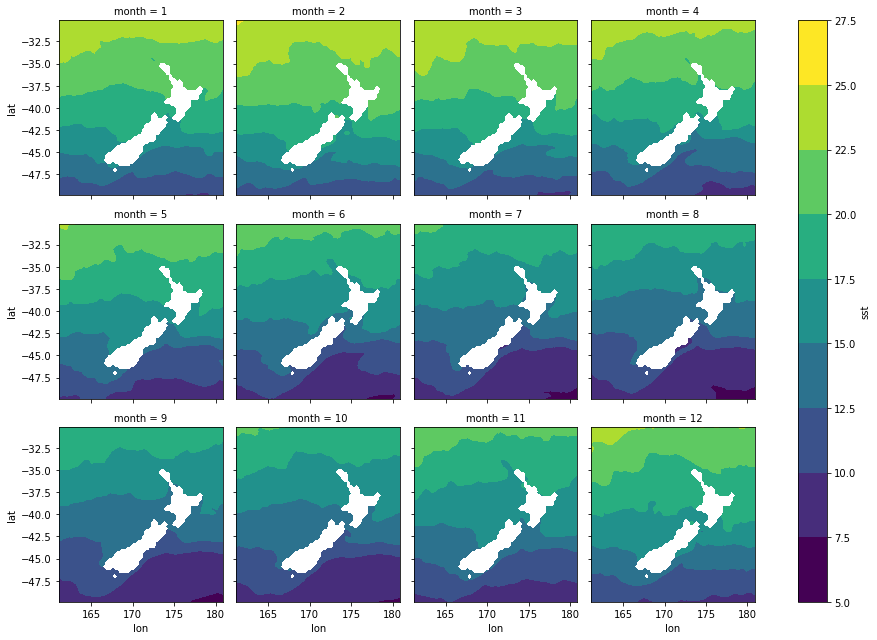

In [221]:
obs_edges[varname].plot.contourf(col='month', col_wrap=4, levels=10)

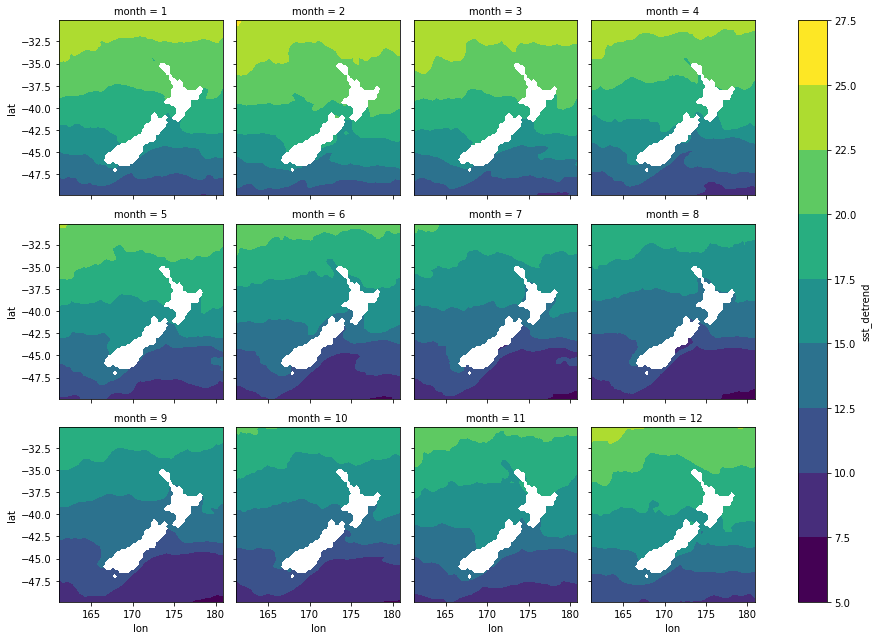

In [222]:
obs_edges[f"{varname}_detrend"].plot.contourf(col='month', col_wrap=4, levels=10)

In [223]:
obs_binary = []

for m in np.arange(12) + 1:

    obsm = dset_obs.sel(time=(dset_obs.time.dt.month == m))

    qm = obs_edges.sel(month=m)

    b = obsm >= qm

    obs_binary.append(b * mask_obs)

In [224]:
obs_binary = xr.concat(obs_binary, dim="time")

In [225]:
obs_binary = obs_binary.squeeze()

In [226]:
obs_binary

<xarray.Dataset>
Dimensions:        (lat: 80, lon: 80, time: 499)
Coordinates:
  * lat            (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
  * lon            (lon) float32 161.1 161.4 161.6 161.9 ... 180.4 180.6 180.9
  * time           (time) datetime64[ns] 1982-01-01 1983-01-01 ... 2022-12-01
    category_edge  float64 0.9
    month          (time) int64 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
Data variables:
    sst            (time, lat, lon) float32 dask.array<chunksize=(42, 10, 10), meta=np.ndarray>
    sst_detrend    (time, lat, lon) float32 dask.array<chunksize=(42, 10, 10), meta=np.ndarray>

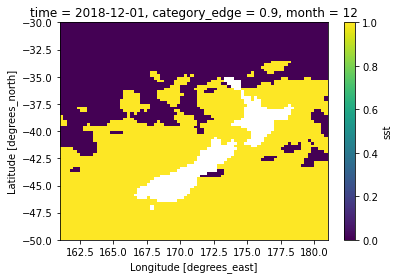

In [227]:
(obs_binary.sel(time="2018-12").squeeze() * mask_obs)["sst"].plot()

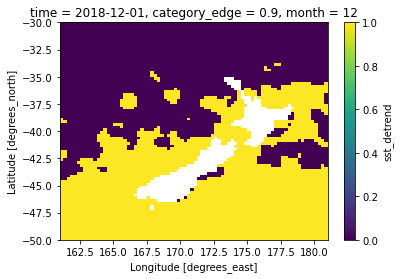

In [229]:
(obs_binary.sel(time="2018-12").squeeze() * mask_obs)[f"{varname}_detrend"].plot()

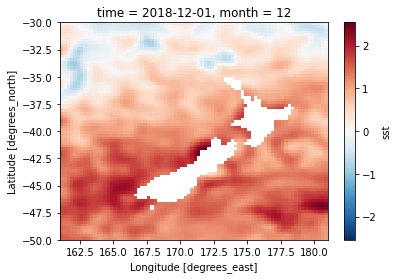

In [230]:
(dset_obs_anoms.sel(time="2018-12").squeeze() * mask_obs)["sst"].plot()

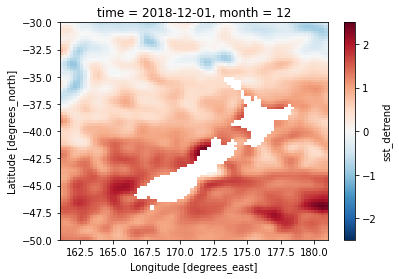

In [231]:
(dset_obs_anoms.sel(time="2018-12").squeeze() * mask_obs)[f"{varname}_detrend"].plot()

### Now reads the percentile climatology for the models 

In [41]:
percentile_climatology = xr.open_zarr('../outputs/percentile_climatologies/percentile_90_climatologies_1993_2016.zarr/')

In [42]:
percentile_climatology

<xarray.Dataset>
Dimensions:        (GCM: 9, lat: 80, lon: 80, month: 12, step: 5)
Coordinates:
  * GCM            (GCM) object 'ECMWF' 'UKMO' ... 'ECCC_GEM5_NEMO'
    category_edge  float64 ...
  * lat            (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
  * lon            (lon) float32 161.1 161.4 161.6 161.9 ... 180.4 180.6 180.9
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * step           (step) int64 1 2 3 4 5
Data variables:
    sst            (GCM, month, step, lat, lon) float64 dask.array<chunksize=(3, 6, 3, 40, 40), meta=np.ndarray>

### Now reads in the forecasts 

In [43]:
forecasts_path = '/media/nicolasf/END19101/ICU/data/CDS/operational/forecasts'

In [44]:
forecasts_path = pathlib.Path(forecasts_path)

In [67]:
GCM = 'ECMWF'

In [68]:
gcm = C3S.get_one_GCM(
    dpath=forecasts_path,
    GCM=GCM,
    varname=varname,
    anomalies=False,
    ensemble_mean=False,
    domain=domain,
    detrend=False, 
    start_year = 2017, 
    end_year = 2022
)

getting GCM data from /media/nicolasf/END19101/ICU/data/CDS/operational/forecasts/ECMWF/SST
reading 71 files

first: /media/nicolasf/END19101/ICU/data/CDS/operational/forecasts/ECMWF/SST/ensemble_seas_forecasts_sst_from_2017_01_ECMWF.netcdf
last: /media/nicolasf/END19101/ICU/data/CDS/operational/forecasts/ECMWF/SST/ensemble_seas_forecasts_sst_from_2022_12_ECMWF.netcdf


In [69]:
if GCM == "NCEP":

    print("Interpolating NCEP, calling `interp_NCEP`")

    gcm = utils.interp_NCEP(gcm, sst_hindcast_records="./SST_hindcast_summary.csv")

else:

    gcm[varname] = utils.interpolate_NaN_da(gcm[varname].load())

if period == "seasonal":

    gcm = gcm.rolling({"step": 3}, min_periods=3).mean("step")

    gcm = gcm.sel(step=slice(3, None))

gcm = gcm.transpose("time", "member", "step", "lat", "lon")

if not (obs_to_1deg):

    gcm = gcm.interp_like(dset_obs[["lon", "lat"]])

gcm = gcm.chunk(
    {"member": -1, "time": -1, "step": -1, "lon": "auto", "lat": "auto"}
)

gcm = gcm * mask_obs

gcm = gcm.compute()


In [70]:
forecast_edges = percentile_climatology.sel(GCM=GCM)

In [72]:
# now derive binary forecasts, for each member of the GCM ensemble

forecasts_binary = []

for m in np.arange(12) + 1:

    forecastsm = gcm.sel(time=(gcm.time.dt.month == m))

    qm = forecast_edges.sel(month=m)

    b = forecastsm >= qm

    forecasts_binary.append(b * mask_obs)

forecasts_binary = xr.concat(forecasts_binary, dim="time")

forecasts_binary = forecasts_binary.sortby("time")

In [73]:
forecasts_binary

<xarray.Dataset>
Dimensions:        (time: 71, member: 51, step: 5, lon: 80, lat: 80)
Coordinates:
  * time           (time) datetime64[ns] 2017-01-01 2017-02-01 ... 2022-12-01
  * member         (member) int32 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * step           (step) int64 1 2 3 4 5
  * lon            (lon) float32 161.1 161.4 161.6 161.9 ... 180.4 180.6 180.9
  * lat            (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
    GCM            <U5 'ECMWF'
    category_edge  float64 ...
    month          (time) int64 1 2 3 4 5 6 7 8 9 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst            (time, member, step, lat, lon) float32 dask.array<chunksize=(1, 51, 3, 40, 40), meta=np.ndarray>

In [101]:
import geopandas as gpd

In [138]:
NZ_coastline = gpd.read_file('/home/nicolasf/data/shapefiles/NZ/NZpolygon/NZ_Polgon2.shp') 

In [139]:
NZ_coastline = NZ_coastline.to_crs('EPSG:4326')

In [141]:
NZ_coastline_buffered = NZ_coastline.buffer(2)

/tmp/ipykernel_49699/291819866.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  NZ_coastline_buffered = NZ_coastline.buffer(2)


<AxesSubplot:>

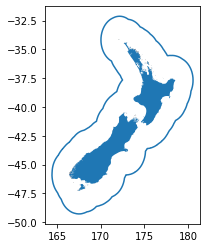

In [142]:
f, ax = plt.subplots()
NZ_coastline.plot(ax=ax)
NZ_coastline_buffered.boundary.plot(ax=ax)

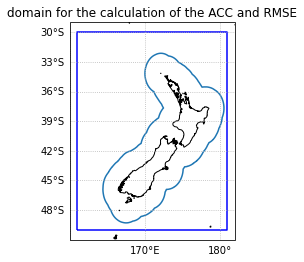

In [143]:
f, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)})

area.geometry.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color="b")

NZ_coastline_buffered.boundary.plot(ax=ax, transform=ccrs.PlateCarree())

ax.coastlines(resolution="10m")
ax.set_title("domain for the calculation of the ACC and RMSE")


gl = ax.gridlines(
    draw_labels=True,
    linestyle=":",
    xlocs=np.arange(-180, 180, 10),
    crs=ccrs.PlateCarree(),
)
gl.top_labels = False
gl.right_labels = False

### creates a mask 

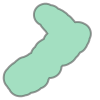

In [148]:
NZ_coastline_buffered.values[0]

In [150]:
NZ_coastline_buffered.to_frame(name='geometry')

,geometrey
0,"POLYGON ((164.42599 -45.91816, 164.42598 -45.9..."


In [232]:
obs_binary = geo.make_mask_from_gpd(obs_binary, NZ_coastline_buffered.to_frame(name='geometry'), subset=False, domain_buffer=0.0)

In [233]:
obs_binary

<xarray.Dataset>
Dimensions:        (lat: 80, lon: 80, time: 499)
Coordinates:
  * lat            (lat) float32 -49.88 -49.62 -49.38 ... -30.62 -30.38 -30.12
  * lon            (lon) float32 161.1 161.4 161.6 161.9 ... 180.4 180.6 180.9
  * time           (time) datetime64[ns] 1982-01-01 1983-01-01 ... 2022-12-01
    category_edge  float64 0.9
    month          (time) int64 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
Data variables:
    sst            (time, lat, lon) float32 dask.array<chunksize=(42, 10, 10), meta=np.ndarray>
    sst_detrend    (time, lat, lon) float32 dask.array<chunksize=(42, 10, 10), meta=np.ndarray>
    mask           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [234]:
MHW_record = obs_binary.copy()

In [235]:
MHW_record = MHW_record[f"{varname}_detrend"] * MHW_record['mask']

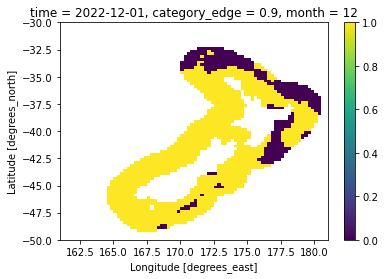

In [236]:
MHW_record.isel(time=-1).plot()

In [237]:
MHW_record = MHW_record.stack(z=('lat','lon'))

In [238]:
MHW_record = MHW_record.dropna('z')

In [239]:
MHW_record = MHW_record.mean('z')

In [240]:
MHW_record_df = MHW_record.to_pandas()

In [241]:
MHW_record_df = MHW_record_df.loc['2017':,]

<AxesSubplot:xlabel='time'>

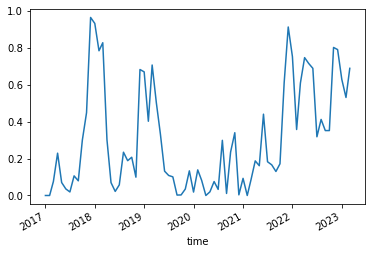

In [257]:
MHW_record_df.plot()

In [243]:
dset_obs_anoms = geo.make_mask_from_gpd(dset_obs_anoms, NZ_coastline_buffered.to_frame(name='geometry'), subset=False, domain_buffer=0.0)

In [245]:
coastal_anoms = dset_obs_anoms.copy()

In [247]:
coastal_anoms = coastal_anoms[[f"{varname}_detrend"]] * coastal_anoms['mask']

In [248]:
coastal_anoms = coastal_anoms.stack(z=('lat','lon'))

In [249]:
coastal_anoms = coastal_anoms.dropna('z')

In [250]:
coastal_anoms = coastal_anoms.mean('z')

In [251]:
coastal_anoms_df = coastal_anoms.to_pandas()

In [252]:
coastal_anoms_df = coastal_anoms_df.loc['2017':,]

<AxesSubplot:xlabel='time'>

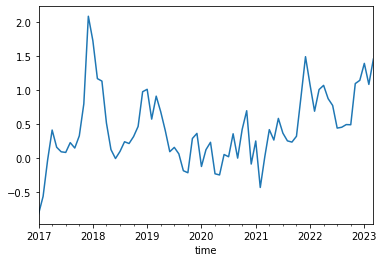

In [254]:
coastal_anoms_df[f"{varname}_detrend"].plot()

Text(0, 0.5, '% of grid points in MHW condition')

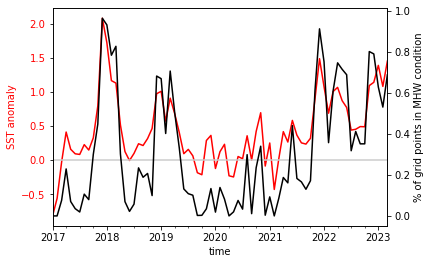

In [285]:
f, ax = plt.subplots()

coastal_anoms_df[f"{varname}_detrend"].plot(ax=ax, color='r')

ax.tick_params(axis='y', labelcolor='r')

ax.set_ylabel('SST anomaly', color='r')

ax.axhline(0, color='0.8')

ax2 = ax.twinx()

MHW_record_df.plot(ax=ax2, color='k')

ax2.tick_params(axis='y', labelcolor='k')

ax2.set_ylabel('% of grid points in MHW condition')



<AxesSubplot:xlabel='time'>

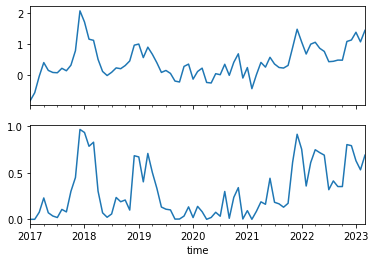

In [276]:
f, axes = plt.subplots(nrows=2, sharex=True)

axes = axes.flat 

ax = axes[0]

coastal_anoms_df[f"{varname}_detrend"].plot(ax=ax)


ax = axes[1]


MHW_record_df.plot(ax=ax)


In [275]:
MHW_record_df = MHW_record_df.sort_index()

In [271]:
MHW_record_df

time
2017-01-01    0.000000
2018-01-01    0.932636
2019-01-01    0.670151
2020-01-01    0.018583
2021-01-01    0.092915
                ...   
2018-12-01    0.682927
2019-12-01    0.133566
2020-12-01    0.003484
2021-12-01    0.913473
2022-12-01    0.790941
Length: 75, dtype: float64

In [191]:
ess = MHW_record_df.rolling(window=5, min_periods=5).sum()

<AxesSubplot:xlabel='time'>

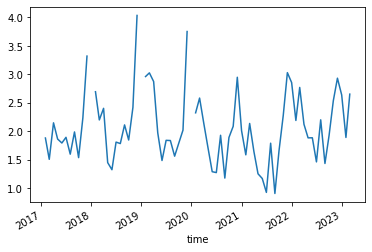

In [192]:
ess.plot()

In [183]:
plt.subplot_mosaic?

Signature:
plt.subplot_mosaic(
    mosaic,
    *,
    sharex=False,
    sharey=False,
    subplot_kw=None,
    gridspec_kw=None,
    empty_sentinel='.',
    **fig_kw,
)
Docstring:
Build a layout of Axes based on ASCII art or nested lists.

This is a helper function to build complex GridSpec layouts visually.

.. note ::

   This API is provisional and may be revised in the future based on
   early user feedback.

Parameters
----------
mosaic : list of list of {hashable or nested} or str

    A visual layout of how you want your Axes to be arranged
    labeled as strings.  For example ::

       x = [['A panel', 'A panel', 'edge'],
            ['C panel', '.',       'edge']]

    produces 4 axes:

    - 'A panel' which is 1 row high and spans the first two columns
    - 'edge' which is 2 rows high and is on the right edge
    - 'C panel' which in 1 row and 1 column wide in the bottom left
    - a blank space 1 row and 1 column wide in the bottom center

    Any of the entries in the lay

In [177]:
MHW_record_df.rolling({'time':12})

ValueError: window must be an integer 0 or greater

### reads the NZ coastline 